In [105]:
pip install lightning

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 19.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 16.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 18.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 17.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 32.2 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found existing installation: n

In [126]:
from torch import nn
from d2l import torch as d2l
import torch
import pandas as pd
import collections
import math
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence


if torch.cuda.is_available():
    print("setting cuda as default!")
    torch.set_default_device("cuda")
    torch.set_default_dtype(torch.float32)
else:
    print("cuda not available")

setting cuda as default!


In [107]:
df = pd.read_csv('dataset.tcsv', usecols=[0, 1], header=None, sep='\t') 
reverted = df[df.columns[::-1]]
reverted.to_csv('pt-eng.tcsv', index=False, header=False, sep='\t')

In [108]:

class MTPtEng(d2l.DataModule):  #@save
    """The Portugues-English dataset."""
    def _download(self):
        with open('pt-eng.tcsv', encoding='utf-8') as f:
            return f.read()

data = MTPtEng()
raw_text = data._download()
print(raw_text[:74])

Vai.	Go.
Vá.	Go.
Oi.	Hi.
Corre!	Run!
Corra!	Run!
Corram!	Run!
Corre!	Run.



In [109]:
@d2l.add_to_class(MTPtEng)  #@save
def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

text = data._preprocess(raw_text)
print(text[:74])


vai .	go .
vá .	go .
oi .	hi .
corre !	run !
corra !	run !
corram !	run !



In [110]:
@d2l.add_to_class(MTPtEng)  #@save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

src, tgt = data._tokenize(text)
src[:6], tgt[:6]

([['vai', '.', '<eos>'],
  ['vá', '.', '<eos>'],
  ['oi', '.', '<eos>'],
  ['corre', '!', '<eos>'],
  ['corra', '!', '<eos>'],
  ['corram', '!', '<eos>']],
 [['go', '.', '<eos>'],
  ['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>']])

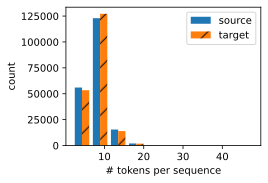

In [111]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', src, tgt);

In [112]:
@d2l.add_to_class(MTPtEng)  #@save
def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTPtEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())

@d2l.add_to_class(MTPtEng)  #@save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

In [113]:
from torch.utils.data import DataLoader

@d2l.add_to_class(MTPtEng)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    generator = torch.Generator(device='cuda')  # <-- ensure CPU generator
    return DataLoader(
        torch.utils.data.TensorDataset(*(a[idx] for a in self.arrays)),
        batch_size=self.batch_size,
        shuffle=train,
        generator=generator
    )

In [114]:
data = MTPtEng(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

source: tensor([[  5,   0,   3,   4,   4,   4,   4,   4,   4],
        [137,  46, 100,   0,   3,   4,   4,   4,   4],
        [ 79,   2,   3,   4,   4,   4,   4,   4,   4]], device='cuda:0',
       dtype=torch.int32)
decoder input: tensor([[  3,  52,  77,   0,   4,   5,   5,   5,   5],
        [  3, 130,  77,   2,   4,   5,   5,   5,   5],
        [  3, 144, 142,   2,   4,   5,   5,   5,   5]], device='cuda:0',
       dtype=torch.int32)
source len excluding pad: tensor([3, 5, 3], device='cuda:0', dtype=torch.int32)
label: tensor([[ 52,  77,   0,   4,   5,   5,   5,   5,   5],
        [130,  77,   2,   4,   5,   5,   5,   5,   5],
        [144, 142,   2,   4,   5,   5,   5,   5,   5]], device='cuda:0',
       dtype=torch.int32)


In [122]:
@d2l.add_to_class(MTPtEng)  #@save
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

src, tgt, _,  _ = data.build(['oi .'], ['hi .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['oi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [123]:
class Encoder(nn.Module):  #@save
    """The base encoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError

In [124]:
class Decoder(nn.Module):  #@save
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [121]:
class EncoderDecoder(d2l.Classifier):  #@save
    """The base class for the encoder--decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

In [127]:
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [130]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

In [131]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [132]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [133]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [134]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

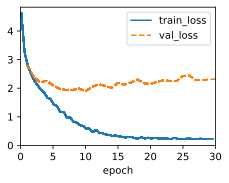

In [136]:
data = MTPtEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [137]:
@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

In [138]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [157]:
pt = ['vai .', 'estou velho .', 'ele veio .', 'eu tentei .']
engs = ['go .', "i'm old .", 'he came .', 'i tried .']
preds, _ = model.predict_step(
    data.build(pt, engs), d2l.try_gpu(), data.num_steps)
for pt, en, p in zip(pt, engs, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{pt} => {translation}, bleu,'
          f'{bleu(" ".join(translation), en, k=2):.3f}')

vai . => ['go', '.'], bleu,1.000
estou velho . => ["i'm", 'old', '.'], bleu,1.000
ele veio . => ['he', 'came', '.'], bleu,1.000
eu tentei . => ['i', 'tried', '.'], bleu,1.000
